# A neural-network framework for modelling auditory sensory cells and synapses

Python notebook for reproducing the evaluation results of the two additional CNN models, corresponding to the Dierich et al. IHC model and the Zilany et al. ANF model. The Dierich2020 CNN IHC model is evaluated using the BM outputs of the reference Verhulst2018 cochlear model (generated here), while the Zilany2014 CNN ANF model is evaluated using the IHC outputs of the reference Zilany2014 ANF model (loaded from pre-simulated csv files).

## Prerequisites

- To run the full notebook for the first time, you'll have to compile the cochlea_utils.c file that is used for solving the TL model of the cochlea. This requires some C++ compiler which should be installed beforehand (more information can be found here). In a terminal, run from the Verhulstetal2018 folder:  
For Mac/Linux: ` gcc -shared -fpic -O3 -ffast-math -o tridiag.so cochlea_utils.c `  
For Windows: ` gcc -shared -fpic -O3 -ffast-math -o tridiag.dll cochlea_utils.c `

- Install numpy, scipy, keras and tensorflow

- If running on google colab: add the following as a code block and run it to compile cochlea_utils.c in the runtime machine:  
` !gcc -shared -fpic -O3 -ffast-math -o tridiag.so cochlea_utils.c `

## Import required python packages and functions
Import required python packages and define the necessary parameters.
**Notice that for all the simulations, the reference models operate at 100kHz and the CNN models operate at 20kHz.**

In [1]:
import scipy.signal as sp_sig
import numpy as np
import keras
import tensorflow as tf
import matplotlib.pyplot as plt

from Verhulstetal2018.get_tl_vbm import tl_vbm
from extra_functions import *
from time import time

Using TensorFlow backend.


In [2]:
# Define model specific variables
ds_rate = 2 # downsampling rate of the frequency channels of the reference model
fs_connear = 20e3
fs_tl = 100e3
ds_factor = int(fs_tl / fs_connear)
p0 = 2e-5 # calibrate to 2e-5 Pascal
# load CFs 
CF_connear = np.loadtxt('connear/cf.txt')*1e3
# scaling values for the CoNNear models
cochlea_scaling = 1e6
ihc_scaling = 1e1
an_scaling = 1e-2

## IHC stage
The input dimensions for the CNN models are (b x L x Ncf), where b is the batch-size (for loading multiple stimuli simultaneously), L is the input length (including the context) and Ncf are the frequency channels.

The ihc.json file can be loaded for the full-channel model (201 channels) or the ihc_1cf.json file for the 1-channel model. At the first block of each individual section, the necessary model is loaded and the rest of the parameters are defined.

The inputs for both the reference Verhulst2018 IHC model and the Dierich2020 CNN model were the BM outputs extracted from the TL cochlear model of Verhulst et al., thus the two models are directly compared here using the same stimuli.

### IHC excitation patterns
Compare the simulated average IHC receptor potentials across CF for tone stimuli presented at levels between 0 and 90 dB SPL.
**You can change the `f_tone` variable to have tone stimuli of different frequencies, say 500Hz, 1kHz, 2kHz, etc..**

In [3]:
modeldir = 'Dierich2020/' # Dierich et al. CNN model directory
# Define the IHC model hyperparameters
context_left = 256
context_right = 256
Nenc = 3 # number of layers in the encoder - check for the input size
# Load the 201-channel IHC model to simulate for all CFs
N_cf = 201
ihc = load_connear_model(modeldir,json_name="/ihc.json",weights_name="/ihc.h5",name="ihc_model")
ihc.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "ihc_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bmm_input (InputLayer)       (None, 2560, 201)         0         
_________________________________________________________________
model_2 (Model)              (None, 2048, 201)         1317505   
Total params: 1,317,505
Trainable params: 1,317,505
Non-trainable params: 0
_________________________________________________________________


In [4]:
# Define the pure tone stimulus
f_tone = 1e3 # frequency of the pure tone
L = np.arange(0., 91., 10.) # levels from 0 to 90dB SPL
stim_dur = 102.4e-3 # duration of the stimulus - 102.4 ms correspond to 2048 samples (fs = 20 kHz)
silence_left = 12.8e-3 # silence before the onset of the stimulus - 12.8 ms correspond to 256 samples (context)
silence_right = 12.8e-3 # silence after the stimulus - 256 samples
win_dur = 5.0e-3 # 5ms long hanning window for gradual onset

# make stimulus
t = np.arange(0., stim_dur, 1./fs_tl)
stim_sin = np.sin(2 * np.pi * f_tone * t) # generate the pure tone
# apply hanning window
winlength = int(2*win_dur * fs_tl)
win = sp_sig.windows.hann(winlength) # double-sided hanning window
stim_sin[:int(winlength/2)] = stim_sin[:int(winlength/2)] * win[:int(winlength/2)]
stim_sin[-int(winlength/2):] = stim_sin[-int(winlength/2):] * win[int(winlength/2):]
total_length = int(silence_left * fs_tl) + len(stim_sin) + int(silence_right * fs_tl)
stim = np.zeros((len(L), total_length))
stimrange = range(int(silence_left * fs_tl), int(silence_left * fs_tl) + len(stim_sin))
for i in range(len(L)):
    stim[i, stimrange] = p0 * 10**(L[i]/20) * stim_sin / rms(stim_sin) # calibrate 

############ Verhulstetal ############
# get the outputs of the reference model 
output = tl_vbm(stim, L)

CF_tl = output[0]['cf'][::ds_rate] # center frequencies
window_length = int(total_length / ds_factor) # window length of the downsampled outputs
tl_target = np.zeros((len(L), window_length, N_cf)) # pre-allocate
ihc_target = np.zeros((len(L), window_length, N_cf))
for i in range(len(L)):
    tl_target[i,:,:] = sp_sig.resample_poly(output[i]['v'][:,::ds_rate], fs_connear, fs_tl) # cochlear output
    ihc_target[i,:,:] = sp_sig.resample_poly(output[i]['ihc'][:,::ds_rate], fs_connear, fs_tl) # IHC output
del output # remove the output variable to free-up some memory
    
# remove context from the corresponding output
ihc_target = ihc_target[:, context_left:-context_right,:]
# apply proper scaling for feeding to the CoNNear
tl_target = tl_target * cochlea_scaling # scaling for the cochlear input

# compute the mean across CF for each level
ihc_target_mean = np.mean(ihc_target,axis=1)

############ CNN model #################
# check the time dimension size
if tl_target.shape[1] % 2**Nenc: # input size needs to be a multiple of 8
    Npad = int(np.ceil(tl_target.shape[1]/(2**Nenc)))*(2**Nenc)-tl_target.shape[1]
    tl_target = np.pad(tl_target,((0,0),(0,Npad),(0,0))) # zero-pad
# simulate
ihc_connear = ihc.predict(tl_target)
ihc_connear = ihc_connear / ihc_scaling # scaling for the IHC output

# compute the mean across CF for each level
ihc_connear_mean = np.mean(ihc_connear,axis=1)

running human auditory model 2018: Verhulst, Altoe, Vasilkov
cochlear simulation: done



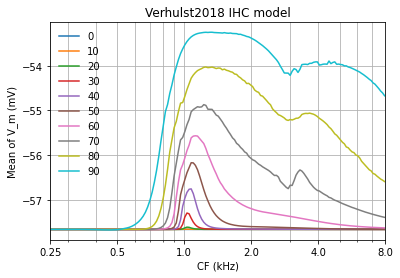

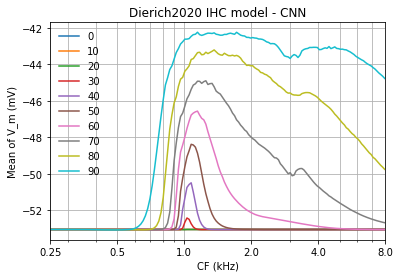

In [5]:
############ Plots ###################
# Plot the mean Vihc patterns for the reference model
CF_rep=np.tile(CF_tl, (len(L),1))
plt.semilogx(CF_rep.T/1e3, 1e3*ihc_target_mean.T)
plt.xlim(0.25,8.), plt.grid(which='both'), 
plt.xticks(ticks=(0.25, 0.5, 1., 2., 4., 8.) , labels=(0.25, 0.5, 1., 2., 4., 8.))
#plt.ylim(-59, -49.5)
plt.xlabel('CF (kHz)')
plt.ylabel('Mean of V_m (mV)')
plt.title('Verhulst2018 IHC model')
plt.legend(L.astype(int), frameon=False)
plt.show()

# Plot the mean Vihc patterns for the CoNNear model
CF_rep=np.tile(CF_connear, (len(L),1))
plt.semilogx(CF_rep.T/1e3, 1e3*ihc_connear_mean.T)
plt.xlim(0.25,8.), plt.grid(which='both'), 
plt.xticks(ticks=(0.25, 0.5, 1., 2., 4., 8.) , labels=(0.25, 0.5, 1., 2., 4., 8.))
#plt.ylim(-59, -49.5)
plt.xlabel('CF (kHz)')
plt.ylabel('Mean of V_m (mV)')
plt.title('Dierich2020 IHC model - CNN')
plt.legend(L.astype(int), frameon=False)
plt.show()

del ihc # remove the connear model variable to free-up some memory

### IHC AC-DC ratio
Compare the ratio of the AC and DC components of the IHC responses across CF. 

In [6]:
modeldir = 'Dierich2020/' # Dierich et al. CNN model directory
# Define the IHC model hyperparameters
context_left = 256
context_right = 256
Nenc = 3 # number of layers in the encoder - check for the input size
# Load the 1-channel IHC model for this section - the results are computed for individual CFs
N_cf = 1
ihc = load_connear_model(modeldir,json_name="/ihc_1cf.json",weights_name="/ihc.h5",name="ihc_model")
#ihc.summary()

In [7]:
# Define the pure tone stimuli
N = 10 # number of frequencies to simulate between 0.15 and 8 kHz
f_tones = np.logspace(np.log10(150),np.log10(8000),num=N) # pick N frequencies in logarithmic spacing
# match the tone frequencies to the corresponding CFs
for j, f_tone in enumerate(f_tones):
    fno, _ = min(enumerate(CF_connear), key=lambda x: abs( x [1]- f_tone))
    f_tones[j] = CF_connear[int(fno)]
    
L = [80.] # 80 dB SPL
stim_dur = 80e-3 # duration of the stimulus
silence_left = 35.2e-3 # silence before the onset of the stimulus - 12.8 ms correspond to 256 samples (context)
silence_right = 12.8e-3 # silence after the stimulus - 256 samples
win_dur = 5.0e-3 # 5ms long ramp window for gradual onset

# indicate the time points of the response for computing the AC and DC components
t_ac_start = silence_left + 50e-3 # 50 ms after the stimulus onset
t_ac_dur = 20e-3 # 20 ms after t_ac_start
t_dc_start = 7.4e-3 # 7.4 ms after the left context (15 ms before the stimulus onset)
t_dc_dur = 10e-3 # 10 ms after t_dc_start

# region of the response for computing the AC component (50 - 70 ms after the stimulus onset)
ac_start = int(t_ac_start * fs_connear) - context_left
ac_end = ac_start + int(t_ac_dur * fs_connear)
ac_reg = np.arange(ac_start,ac_end,1)
# region of the response for computing the DC component (5 - 15 ms before the stimulus onset)
dc_start = int(t_dc_start * fs_connear)
dc_end = dc_start + int(t_dc_dur * fs_connear)
dc_reg = np.arange(dc_start,dc_end,1)

# make stimuli
t = np.arange(0., stim_dur, 1./fs_tl)
winlength = int(2*win_dur * fs_tl)
win = sp_sig.windows.bartlett(winlength) # double-sided ramp
total_length = int(silence_left * fs_tl) + len(t) + int(silence_right * fs_tl) 
stim = np.zeros((len(f_tones), total_length))
for j, f_tone in enumerate(f_tones):
    stim_sin = np.sin(2 * np.pi * f_tone * t) # generate the pure tone
    # apply ramp window
    stim_sin[:int(winlength/2)] = stim_sin[:int(winlength/2)] * win[:int(winlength/2)]
    stim_sin[-int(winlength/2):] = stim_sin[-int(winlength/2):] * win[int(winlength/2):]
    stimrange = range(int(silence_left * fs_tl), int(silence_left * fs_tl) + len(stim_sin))
    stim[j, stimrange] = p0 * 10**(L[0]/20) * stim_sin / rms(stim_sin) # calibrate 

############ Verhulstetal ############
# get the outputs of the reference model 
output = tl_vbm(stim, L)

CF_tl = output[0]['cf'][::ds_rate] # center frequencies
window_length = int(total_length / ds_factor) # window length of the downsampled outputs
tl_target = np.zeros((len(f_tones), window_length, N_cf)) # pre-allocate
ihc_target = np.zeros((len(f_tones), window_length, N_cf))
for j, f_tone in enumerate(f_tones):
    # find the CF closest to the stimulus frequency
    No, _ = min(enumerate(CF_tl), key=lambda x: abs(x[1] - f_tone))
    No = int(No)
    # extract the outputs only for the specific CF
    tl_target[j,:,:] = sp_sig.resample_poly(output[j]['v'][:,::ds_rate][:,[No]], fs_connear, fs_tl) # cochlear output
    ihc_target[j,:,:] = sp_sig.resample_poly(output[j]['ihc'][:,::ds_rate][:,[No]], fs_connear, fs_tl) # IHC output  
del output # remove the output variable to free-up some memory

# remove context from the output
ihc_target = ihc_target[:, context_left:-context_right,:]
# apply proper scaling for feeding to the CoNNear
tl_target = tl_target * cochlea_scaling # scaling for the cochlear input

# compute the AC component for each frequency
acm_target = (np.max(ihc_target[:,ac_reg],axis=1)-np.min(ihc_target[:,ac_reg],axis=1))/2
ac_target = acm_target/np.sqrt(2.)
# compute the DC component for each frequency
dcm_target = (np.max(ihc_target[:,dc_reg],axis=1)-np.min(ihc_target[:,dc_reg],axis=1))/2
dc_target = (np.min(ihc_target[:,ac_reg],axis=1)+acm_target)-(np.min(ihc_target[:,dc_reg],axis=1)+dcm_target)

############ CNN model #################
# check the time dimension size
if tl_target.shape[1] % 2**Nenc: # input size needs to be a multiple of 8
    Npad = int(np.ceil(tl_target.shape[1]/(2**Nenc)))*(2**Nenc)-tl_target.shape[1]
    tl_target = np.pad(tl_target,((0,0),(0,Npad),(0,0))) # zero-pad
# simulate
ihc_connear = ihc.predict(tl_target, verbose=1)
ihc_connear = ihc_connear / ihc_scaling # scaling for the IHC output

# compute the AC component for each frequency
acm_connear = (np.max(ihc_connear[:,ac_reg],axis=1)-np.min(ihc_connear[:,ac_reg],axis=1))/2
ac_connear = acm_connear/np.sqrt(2.)
# compute the DC component for each frequency
dcm_connear = (np.max(ihc_connear[:,dc_reg],axis=1)-np.min(ihc_connear[:,dc_reg],axis=1))/2
dc_connear = (np.min(ihc_connear[:,ac_reg],axis=1)+acm_connear)-(np.min(ihc_connear[:,dc_reg],axis=1)+dcm_connear)

running human auditory model 2018: Verhulst, Altoe, Vasilkov
cochlear simulation: done
10/10 [==============================] - 0s 22ms/step


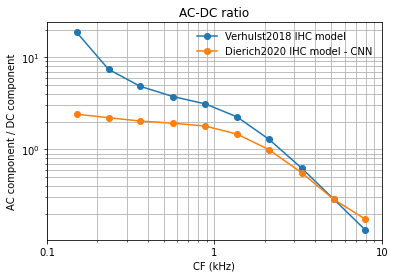

In [8]:
############ Plots ###################
# Plot the logarithmic decrease of the AC/DC ratio across frequency
plt.loglog(f_tones/1e3, ac_target/dc_target,'o-')
plt.loglog(f_tones/1e3, ac_connear/dc_connear,'o-')
plt.xlim(0.1,10.), plt.grid(which='both'), 
plt.xticks(ticks=(0.1,1,10) , labels=(0.1,1,10))
plt.xlabel('CF (kHz)')
plt.ylabel('AC component / DC component')
plt.title('AC-DC ratio')
plt.legend(['Verhulst2018 IHC model','Dierich2020 IHC model - CNN'], frameon=False)
plt.show()

del ihc # remove the connear model variable to free-up some memory

### IHC level growth
Compare the growth of the half-wave rectified IHC receptor potential as a function of sound level.

In [9]:
modeldir = 'Dierich2020/' # Dierich et al. CNN model directory
# Define the IHC model hyperparameters
context_left = 256
context_right = 256
Nenc = 3 # number of layers in the encoder - check for the input size
# Load the 1-channel IHC model
N_cf = 1
ihc = load_connear_model(modeldir,json_name="/ihc_1cf.json",weights_name="/ihc.h5",name="ihc_model")
#ihc.summary()

In [10]:
# Define the pure tone stimuli
f_tone = 4e3 # frequency of the pure tone
# match the tone frequency to the corresponding CF
fno, _ = min(enumerate(CF_connear), key=lambda x: abs( x [1]- f_tone))
f_tone = CF_connear[int(fno)]

L = np.arange(0.,101.,10.) # levels from 0 to 100dB SPL
stim_dur = 80e-3 # duration of the stimulus
silence_left = 35.2e-3 # silence before the onset of the stimulus - 12.8 ms correspond to 256 samples (context)
silence_right = 12.8e-3 # silence after the stimulus - 256 samples
win_dur = 5.0e-3 # 5ms long ramp window for gradual onset

# indicate the time points of the response for computing the AC and DC components
t_ac_start = silence_left + 50e-3 # 50 ms after the stimulus onset
t_ac_dur = 20e-3 # 20 ms after t_ac_start
t_dc_start = 7.4e-3 # 7.4 ms after the left context (15 ms before the stimulus onset)
t_dc_dur = 10e-3 # 10 ms after t_dc_start

# region of the response for computing the AC component (50 - 70 ms after the stimulus onset)
ac_start = int(t_ac_start * fs_connear) - context_left
ac_end = ac_start + int(t_ac_dur * fs_connear)
ac_reg = np.arange(ac_start,ac_end,1)
# region of the response for computing the DC component (5 - 15 ms before the stimulus onset)
dc_start = int(t_dc_start * fs_connear)
dc_end = dc_start + int(t_dc_dur * fs_connear)
dc_reg = np.arange(dc_start,dc_end,1)

# make stimulus
t = np.arange(0., stim_dur, 1./fs_tl)
stim_sin = np.sin(2 * np.pi * f_tone * t) # generate the pure tone
# apply hanning window
winlength = int(2*win_dur * fs_tl)
win = sp_sig.windows.bartlett(winlength) # double-sided ramp
stim_sin[:int(winlength/2)] = stim_sin[:int(winlength/2)] * win[:int(winlength/2)]
stim_sin[-int(winlength/2):] = stim_sin[-int(winlength/2):] * win[int(winlength/2):]
total_length = int(silence_left * fs_tl) + len(stim_sin) + int(silence_right * fs_tl)
stim = np.zeros((len(L), total_length))
stimrange = range(int(silence_left * fs_tl), int(silence_left * fs_tl) + len(stim_sin))
for i in range(len(L)):
    stim[i, stimrange] = p0 * 10**(L[i]/20) * stim_sin / rms(stim_sin) # calibrate 

############ Verhulstetal ############
# get the outputs of the reference model 
output = tl_vbm(stim, L)

CF_tl = output[0]['cf'][::ds_rate] # center frequencies
# find the CF closest to the stimulus frequency
No, _ = min(enumerate(CF_tl), key=lambda x: abs(x[1] - f_tone))
No = int(No)

window_length = int(total_length / ds_factor) # window length of the downsampled outputs
tl_target = np.zeros((len(L), window_length, N_cf)) # pre-allocate
ihc_target = np.zeros((len(L), window_length, N_cf))
for i in range(len(L)):
    # extract the outputs only for the specific CF
    tl_target[i,:,:] = sp_sig.resample_poly(output[i]['v'][:,::ds_rate][:,[No]], fs_connear, fs_tl) # cochlear output
    ihc_target[i,:,:] = sp_sig.resample_poly(output[i]['ihc'][:,::ds_rate][:,[No]], fs_connear, fs_tl) # IHC output
del output # remove the output variable to free-up some memory
    
# remove context from the output
ihc_target = ihc_target[:, context_left:-context_right,:]
# apply proper scaling for feeding to the CoNNear
tl_target = tl_target * cochlea_scaling # scaling for the cochlear input

dcm_target = np.mean(ihc_target[:,dc_reg],axis=1) # compute the DC component 
vihc_target = np.zeros((ihc_target.shape))
for i in range(len(L)):
    vihc_target[i,:] = ihc_target[i,:] - dcm_target[i] #half-wave rectify the response by substracting the DC component
vihc_target_rms = rms(vihc_target,axis=1)

############ CNN model #################
# check the time dimension size
if tl_target.shape[1] % 2**Nenc: # input size needs to be a multiple of 8
    Npad = int(np.ceil(tl_target.shape[1]/(2**Nenc)))*(2**Nenc)-tl_target.shape[1]
    tl_target = np.pad(tl_target,((0,0),(0,Npad),(0,0))) # zero-pad
# simulate
ihc_connear = ihc.predict(tl_target, verbose=1)
ihc_connear = ihc_connear / ihc_scaling # scaling for the IHC output

dcm_connear = np.mean(ihc_connear[:,dc_reg],axis=1) # compute the DC component 
vihc_connear = np.zeros((ihc_connear.shape))
for i in range(len(L)):
    vihc_connear[i,:] = ihc_connear[i,:] - dcm_connear[i] #half-wave rectify the response by substracting the DC component
vihc_connear_rms = rms(vihc_connear,axis=1)

running human auditory model 2018: Verhulst, Altoe, Vasilkov
cochlear simulation: done
11/11 [==============================] - 0s 15ms/step


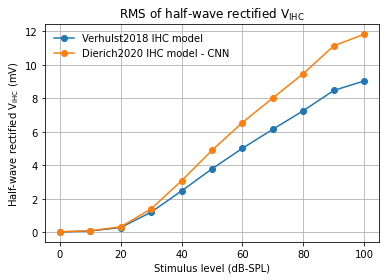

In [11]:
############ Plots ###################
# Plot the RMS of the half-wave rectified response across level
plt.plot(L, 1e3*vihc_target_rms,'o-')
plt.plot(L, 1e3*vihc_connear_rms,'o-')
plt.grid(which='both'), 
#plt.yticks(ticks=np.arange(0.,10.,1.))
plt.xlabel('Stimulus level (dB-SPL)')
plt.ylabel('Half-wave rectified $\mathregular{V_{IHC}}$ (mV)')
plt.title('RMS of half-wave rectified $\mathregular{V_{IHC}}$')
plt.legend(['Verhulst2018 IHC model','Dierich2020 IHC model - CNN'], frameon=False)
plt.show()

del ihc # remove the connear model variable to free-up some memory

## ANF stage
The input dimensions for the CNN models are (b x L x Ncf), where b is the batch-size (for loading multiple stimuli simultaneously), L is the input length (including the context) and Ncf are the frequency channels.

The anfX.json file can be loaded for the full-channel model (201 channels) or the anfX_1cf.json file for the 1-channel model, where X corresponds to the AN fiber type (h for HSR, m for MSR or l for LSR ANF model). At the first block of each individual section, the necessary model is loaded and the rest of the parameters are defined.

The responses of the reference Verhulst2018 ANF model are simulated here using the outputs of the model's IHC stage as inputs. To evaluate the Zilany2014 CNN ANF model, the IHC reponses of the Zilany2014 cochlea-IHC model to the same stimuli are loaded from pre-simulated csv files. As an alternative, a Python implementation or a ported version of the Zilany2014 cochlea-IHC Matlab model can be used to generate the inputs to the CNN ANF model.

### ANF firing rates
Compare the simulated ANF firing rates across time for tone stimuli presented at 70 dB SPL.
**You can change the `f_tone` variable to have tone stimuli of different frequencies, the `f_m` variable for generating amplitude-modulated tones or the `L` variable for having different levels.
Pre-simulated IHC outputs of the Zilany2014 model are only included for two `f_tone` carriers (1kHz and 4kHz tones) and one modulation frequency `f_m ` of 100 Hz.**

In [12]:
modeldir = 'Zilany2014/'
# Define the ANF model hyperparameters
context_left = 7936 # longer left-sided context for the ANF models
context_right = 256
Nenc = 14 # number of layers in the encoder - check for the input size
# Load the 1-channel ANF models
N_cf = 1
anfh = load_connear_model(modeldir,json_name="/anfh_1cf.json",weights_name="/anfh.h5",name="anfh_model")
anfh.summary()
anfm = load_connear_model(modeldir,json_name="/anfm_1cf.json",weights_name="/anfm.h5",name="anfm_model")
anfm.summary()
anfl = load_connear_model(modeldir,json_name="/anfl_1cf.json",weights_name="/anfl.h5",name="anfl_model")
anfl.summary()

Model: "anfh_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bmm_input (InputLayer)       (None, 16384, 1)          0         
_________________________________________________________________
model_3 (Model)              (None, 8192, 1)           1250177   
Total params: 1,250,177
Trainable params: 1,250,177
Non-trainable params: 0
_________________________________________________________________
Model: "anfm_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bmm_input (InputLayer)       (None, 16384, 1)          0         
_________________________________________________________________
model_3 (Model)              (None, 8192, 1)           1250177   
Total params: 1,250,177
Trainable params: 1,250,177
Non-trainable params: 0
_________________________________________________________________
Model: "anfl_mod

In [13]:
# Define the pure tone stimulus
f_tone = 4e3 # frequency of the pure tone
L = [70.] # stimulus level
m = 1 # modulation percentage 
f_m = 100 # modulation frequency - leave empty for pure-tone stimulus (no modulation applied)
#f_m = [] # uncomment for pure-tone stimulus

stim_dur = 400e-3 # duration of the stimulus - 409.6 ms correspond to 8192 samples (fs = 20 kHz)
silence_left = 396.8e-3 + 5e-3 # silence before the onset of the stimulus - 396.8 ms correspond to 7936 samples (left context)
silence_right = 12.8e-3 # silence after the stimulus - 256 samples (right context)
win_dur = 7.8e-3 # 5ms long ramp window for gradual onset

# match the tone frequency to the corresponding CF
fno, _ = min(enumerate(CF_connear), key=lambda x: abs( x [1]- f_tone))
f_tone = CF_connear[int(fno)]

# make stimulus
t = np.arange(0., stim_dur, 1./fs_tl)
if f_m: # if f_m is defined make a SAM tone
    stim_sin = (1 + m * np.cos(2 * np.pi * f_m * t + np.pi)) * np.sin(2 * np.pi * f_tone * t) # generate the SAM tone
else:
    stim_sin = np.sin(2 * np.pi * f_tone * t) # generate the pure tone
# apply ramp
winlength = int(2*win_dur * fs_tl)
win = sp_sig.windows.bartlett(winlength) # double-sided ramp window
stim_sin[:int(winlength/2)] = stim_sin[:int(winlength/2)] * win[:int(winlength/2)]
stim_sin[-int(winlength/2):] = stim_sin[-int(winlength/2):] * win[int(winlength/2):]
total_length = int(silence_left * fs_tl) + len(stim_sin) + int(silence_right * fs_tl)
stim = np.zeros((len(L), total_length))
stimrange = range(int(silence_left * fs_tl), int(silence_left * fs_tl) + len(stim_sin))
for i in range(len(L)):
    stim[i, stimrange] = p0 * 10**(L[i]/20) * stim_sin / rms(stim_sin) # calibrate 

############ Verhulstetal ############
# get the outputs of the reference model 
output = tl_vbm(stim, L)

CF_tl = output[0]['cf'][::ds_rate] # center frequencies
# find the CF closest to the stimulus frequency
No, _ = min(enumerate(CF_tl), key=lambda x: abs(x[1] - f_tone)) # find the CF closest to the stimulus frequency
No = int(No)

window_length = int(total_length / ds_factor) # window length of the downsampled outputs
ihc_target = np.zeros((len(L), window_length, N_cf))
anfh_target = np.zeros((len(L), window_length, N_cf))
anfm_target = np.zeros((len(L), window_length, N_cf))
anfl_target = np.zeros((len(L), window_length, N_cf))
for i in range(len(L)):
    # extract the outputs only for the specific CF
    ihc_target[i,:,:] = sp_sig.resample_poly(output[i]['ihc'][:,::ds_rate][:,[No]], fs_connear, fs_tl) # IHC output
    anfh_target[i,:,:] = output[i]['anfH'][:,::ds_rate][:,[No]] # ANF HSR output
    anfm_target[i,:,:] = output[i]['anfM'][:,::ds_rate][:,[No]] # ANF MSR output
    anfl_target[i,:,:] = output[i]['anfL'][:,::ds_rate][:,[No]] # ANF LSR output
del output # remove the output variable to free-up some memory
    
# remove context from the outputs (and the last dimension)
anfh_target = anfh_target[:, context_left:-context_right, 0]
anfm_target = anfm_target[:, context_left:-context_right, 0]
anfl_target = anfl_target[:, context_left:-context_right, 0]

############ CNN model #################
# load the pre-simulated IHC output of the Zilany2014 model
f = open(modeldir + "ihc_inputs/ihc_toneburst_" + "%1.2f" % f_tone + "Hz_zilany_downsampled.csv", "rb")
Lf = np.arange(0.,101.,10.) # the file contains levels from 0 to 100 dB SPL with a step of 10
ihc_target=np.loadtxt(f, delimiter=",", skiprows=1).T
ihc_target=ihc_target[1:,:] # omit first frequency dimension
ihc_target=np.expand_dims(ihc_target,axis=-1) # fix dimensions
No, _ = min(enumerate(Lf), key=lambda x: abs(x[1] - L)) # find the L closest to the stimulus level
print("Plotting the responses for L = " + str(Lf[int(No)]) + "dB SPL")
ihc_target = ihc_target[[int(No)],:,:] # select the specific level L from the simulations
# apply proper scaling for feeding to the CNN model
ihc_target = ihc_target * ihc_scaling # scaling for the cochlear input

# check the time dimension size
if ihc_target.shape[1] % 2**Nenc: # input size needs to be a multiple of 16384
    Npad = int(np.ceil(ihc_target.shape[1]/(2**Nenc)))*(2**Nenc)-ihc_target.shape[1]
    ihc_target = np.pad(ihc_target,((0,0),(0,Npad),(0,0))) # zero-pad
# simulate
anfh_connear = anfh.predict(ihc_target, verbose=1)
anfm_connear = anfm.predict(ihc_target, verbose=1)
anfl_connear = anfl.predict(ihc_target, verbose=1)
# remove last dimension 
anfh_connear = anfh_connear[:, :, 0]
anfm_connear = anfm_connear[:, :, 0]
anfl_connear = anfl_connear[:, :, 0]
# scale back to the original ANF values
anfh_connear = anfh_connear / an_scaling
anfm_connear = anfm_connear / an_scaling
anfl_connear = anfl_connear / an_scaling

# crop the connear time dimensions to match the size of the reference responses
anfh_connear = anfh_connear[:,:anfh_target.shape[1]]
anfm_connear = anfm_connear[:,:anfm_target.shape[1]]
anfl_connear = anfl_connear[:,:anfl_target.shape[1]]

running human auditory model 2018: Verhulst, Altoe, Vasilkov
cochlear simulation: done
Plotting the responses for L = 70.0dB SPL
1/1 [==============================] - 0s 318ms/step


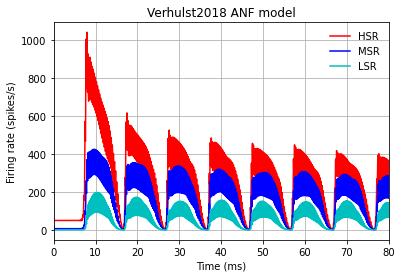

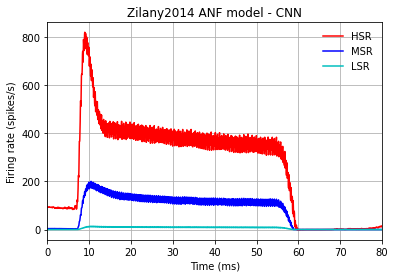

In [14]:
############ Plots ###################
t_ds = np.arange(0., anfh_target.shape[1]/fs_connear, 1./fs_connear) # time vector of the (downsampled) responses

# Plot the firing rate patterns for the reference model
plt.plot(1e3*t_ds,anfh_target.T,'r')
plt.plot(1e3*t_ds,anfm_target.T,'b')
plt.plot(1e3*t_ds,anfl_target.T,'c')
plt.xlim(0,80.), plt.grid(which='both'), 
plt.xlabel('Time (ms)')
plt.ylabel('Firing rate (spikes/s)')
plt.title('Verhulst2018 ANF model')
plt.legend(['HSR','MSR','LSR'], frameon=False)
plt.show()

# Plot the firing rate patterns for the CoNNear model
plt.plot(1e3*t_ds,anfh_connear.T,'r')
plt.plot(1e3*t_ds,anfm_connear.T,'b')
plt.plot(1e3*t_ds,anfl_connear.T,'c')
plt.xlim(0,80.), plt.grid(which='both'), 
plt.xlabel('Time (ms)')
plt.ylabel('Firing rate (spikes/s)')
plt.title('Zilany2014 ANF model - CNN')
plt.legend(['HSR','MSR','LSR'], frameon=False)
plt.show()

del anfh, anfm, anfl # remove the connear models variables to free-up some memory

### ANF rate-level curves
Compare the simulated ANF rate-level curves for the three fiber models.
**You can change the `f_tone` variable to get the curves of 1 kHz or 4 kHz.**

In [3]:
modeldir = 'Zilany2014/'
# Define the ANF model hyperparameters
context_left = 7936
context_right = 256
Nenc = 14 # number of layers in the encoder - check for the input size
# Load the 1-channel ANF models
N_cf = 1
anfh = load_connear_model(modeldir,json_name="/anfh_1cf.json",weights_name="/anfh.h5",name="anfh_model")
#anfh.summary()
anfm = load_connear_model(modeldir,json_name="/anfm_1cf.json",weights_name="/anfm.h5",name="anfm_model")
#anfm.summary()
anfl = load_connear_model(modeldir,json_name="/anfl_1cf.json",weights_name="/anfl.h5",name="anfl_model")
#anfl.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [4]:
# Define the pure tone stimulus
f_tone = 4e3 # frequency of the pure tone
L = np.arange(0.,101.,10.) # levels from 0 to 100 dB SPL

stim_dur = 50e-3 # duration of the stimulus - 409.6 ms correspond to 8192 samples (fs = 20 kHz)
silence_left = 396.8e-3 + 5e-3 # silence before the onset of the stimulus - 396.8 ms correspond to 7936 samples (left context)
silence_right = 12.8e-3 # silence after the stimulus - 256 samples (right context)
win_dur = 2.5e-3 # 2.5ms long ramp window for gradual onset

# match the tone frequency to the corresponding CF
fno, _ = min(enumerate(CF_connear), key=lambda x: abs( x [1]- f_tone))
f_tone = CF_connear[int(fno)]

# indicate the region of the response for computing the mean - 10-40 ms after the stimulus onset
index_start = int((silence_left + 10e-3) * fs_connear) - context_left # omit silence + 10 ms (15ms = 300 samples)
index_end = index_start + int(30e-3 * fs_connear) # keep 30 ms of response after (30ms = 600 samples)
stim_reg = np.arange(index_start,index_end,1) # stimulus region
    
# make stimulus
t = np.arange(0., stim_dur, 1./fs_tl)
stim_sin = np.sin(2 * np.pi * f_tone * t) # generate the pure tone
# apply ramp
winlength = int(2*win_dur * fs_tl)
win = sp_sig.windows.bartlett(winlength) # double-sided ramp window
stim_sin[:int(winlength/2)] = stim_sin[:int(winlength/2)] * win[:int(winlength/2)]
stim_sin[-int(winlength/2):] = stim_sin[-int(winlength/2):] * win[int(winlength/2):]
total_length = int(silence_left * fs_tl) + len(stim_sin) + int(silence_right * fs_tl)
stim = np.zeros((len(L), total_length))
stimrange = range(int(silence_left * fs_tl), int(silence_left * fs_tl) + len(stim_sin))
for i in range(len(L)):
    stim[i, stimrange] = p0 * 10**(L[i]/20) * stim_sin / rms(stim_sin) # calibrate 

############ Verhulstetal ############
# get the outputs of the reference model 
output = tl_vbm(stim, L)

CF_tl = output[0]['cf'][::ds_rate] # center frequencies
# find the CF closest to the stimulus frequency
No, _ = min(enumerate(CF_tl), key=lambda x: abs(x[1] - f_tone))
No = int(No)

window_length = int(total_length / ds_factor) # window length of the downsampled outputs
ihc_target = np.zeros((len(L), window_length, N_cf))
anfh_target = np.zeros((len(L), window_length, N_cf))
anfm_target = np.zeros((len(L), window_length, N_cf))
anfl_target = np.zeros((len(L), window_length, N_cf))
for i in range(len(L)):
    # extract the outputs only for the specific CF
    ihc_target[i,:,:] = sp_sig.resample_poly(output[i]['ihc'][:,::ds_rate][:,[No]], fs_connear, fs_tl) # IHC output
    anfh_target[i,:,:] = output[i]['anfH'][:,::ds_rate][:,[No]] # ANF HSR output
    anfm_target[i,:,:] = output[i]['anfM'][:,::ds_rate][:,[No]] # ANF MSR output
    anfl_target[i,:,:] = output[i]['anfL'][:,::ds_rate][:,[No]] # ANF LSR output
del output # remove the output variable to free-up some memory
    
# remove context from the outputs (and last dimension)
anfh_target = anfh_target[:, context_left:-context_right, 0]
anfm_target = anfm_target[:, context_left:-context_right, 0]
anfl_target = anfl_target[:, context_left:-context_right, 0]

# compute the mean firing rate over the stimulus region
anfh_target_mean = np.mean(anfh_target[:,stim_reg],axis=1)
anfm_target_mean = np.mean(anfm_target[:,stim_reg],axis=1)
anfl_target_mean = np.mean(anfl_target[:,stim_reg],axis=1)

############ CNN model #################
# load the pre-simulated IHC output of the Zilany2014 model
f = open(modeldir + "ihc_inputs/ihc_toneburst_" + "%1.2f" % f_tone + "Hz_zilany_downsampled.csv", "rb")
Lf = np.arange(0.,101.,10.) # the file contains levels from 0 to 100 dB SPL with a step of 10
indices = np.where(np.in1d(Lf, L))[0] # find indices in the stored file
ihc_target=np.loadtxt(f, delimiter=",", skiprows=1).T
ihc_target=ihc_target[1:,:] # omit first frequency dimension
ihc_target=ihc_target[indices,:] #get level indices
ihc_target=np.expand_dims(ihc_target,axis=-1) # fix dimensions
# apply proper scaling for feeding to the CNN model
ihc_target = ihc_target * ihc_scaling # scaling for the cochlear input

# check the time dimension size
if ihc_target.shape[1] % 2**Nenc: # input size needs to be a multiple of 16384
    Npad = int(np.ceil(ihc_target.shape[1]/(2**Nenc)))*(2**Nenc)-ihc_target.shape[1]
    ihc_target = np.pad(ihc_target,((0,0),(0,Npad),(0,0))) # zero-pad
# simulate
anfh_connear = anfh.predict(ihc_target, verbose=1)
anfm_connear = anfm.predict(ihc_target, verbose=1)
anfl_connear = anfl.predict(ihc_target, verbose=1)

# remove last dimension 
anfh_connear = anfh_connear[:, :, 0]
anfm_connear = anfm_connear[:, :, 0]
anfl_connear = anfl_connear[:, :, 0]
# scale back to the original ANF values
anfh_connear = anfh_connear / an_scaling
anfm_connear = anfm_connear / an_scaling
anfl_connear = anfl_connear / an_scaling

# compute the mean firing rate over the stimulus region
anfh_connear_mean = np.mean(anfh_connear[:,stim_reg],axis=1)
anfm_connear_mean = np.mean(anfm_connear[:,stim_reg],axis=1)
anfl_connear_mean = np.mean(anfl_connear[:,stim_reg],axis=1)

running human auditory model 2018: Verhulst, Altoe, Vasilkov
cochlear simulation: done

11/11 [==============================] - 1s 55ms/step


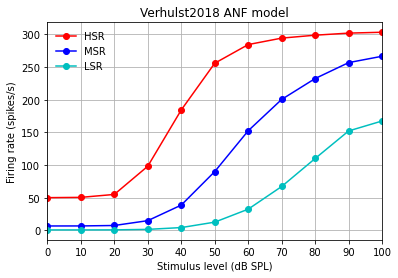

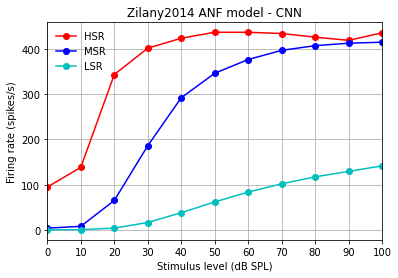

In [5]:
############ Plots ###################
# Plot the rate-level curves for the reference model
plt.plot(anfh_target_mean.T,'ro-')
plt.plot(anfm_target_mean.T,'bo-')
plt.plot(anfl_target_mean.T,'co-')
plt.xlim(0,10), plt.grid(which='both'), 
plt.xticks(ticks=L/10 , labels=L.astype(int))
plt.xlabel('Stimulus level (dB SPL)')
plt.ylabel('Firing rate (spikes/s)')
plt.title('Verhulst2018 ANF model')
plt.legend(['HSR','MSR','LSR'], frameon=False)
plt.show()

# Plot the rate-level curves for the CoNNear model
plt.plot(anfh_connear_mean.T,'ro-')
plt.plot(anfm_connear_mean.T,'bo-')
plt.plot(anfl_connear_mean.T,'co-')
plt.xlim(0,10), plt.grid(which='both'), 
plt.xticks(ticks=L/10 , labels=L.astype(int))
plt.xlabel('Stimulus level (dB SPL)')
plt.ylabel('Firing rate (spikes/s)')
plt.title('Zilany2014 ANF model - CNN')
plt.legend(['HSR','MSR','LSR'], frameon=False)
plt.show()

del anfh, anfm, anfl # remove the connear models variables to free-up some memory

### ANF synchrony-level functions
Compare the simulated ANF synchrony-level functions for the three fiber models.
**You can change the `f_tone` variable to get the curves of 1 kHz or 4 kHz.**

In [9]:
modeldir = 'Zilany2014/'
# Define the ANF model hyperparameters
context_left = 7936
context_right = 256
Nenc = 14 # number of layers in the encoder - check for the input size
# Load the 1-channel ANF models
N_cf = 1
anfh = load_connear_model(modeldir,json_name="/anfh_1cf.json",weights_name="/anfh.h5",name="anfh_model")
#anfh.summary()
anfm = load_connear_model(modeldir,json_name="/anfm_1cf.json",weights_name="/anfm.h5",name="anfm_model")
#anfm.summary()
anfl = load_connear_model(modeldir,json_name="/anfl_1cf.json",weights_name="/anfl.h5",name="anfl_model")
#anfl.summary()

In [10]:
# Define the pure tone stimulus
f_tone = 4e3 # frequency of the pure tone
L = np.arange(0.,101.,10.) # levels from 0 to 100 dB SPL with a step of 10 - in the paper the step is 5
f_m = 100 # modulation frequency
m = 1 # modulation percentage 

stim_dur = 400e-3 # duration of the stimulus - 409.6 ms correspond to 8192 samples (fs = 20 kHz)
silence_left = 396.8e-3 + 5e-3 # silence before the onset of the stimulus - 396.8 ms correspond to 7936 samples (left context)
silence_right = 12.8e-3 # silence after the stimulus - 256 samples (right context)
win_dur = 7.8e-3 # 7.8ms long ramp window for gradual onset

# match the tone frequency to the corresponding CF
fno, _ = min(enumerate(CF_connear), key=lambda x: abs( x [1]- f_tone))
f_tone = CF_connear[int(fno)]

# indicate the region of interest for computing the synchrony
index_start = int(silence_left * fs_connear) - context_left # omit silence (5ms = 100 samples)
index_end = index_start + int(stim_dur * fs_connear) # keep for the stimulus duration (400ms = 8000 samples)
stim_reg = np.arange(index_start,index_end,1) # stimulus region

# make stimulus
t = np.arange(0., stim_dur, 1./fs_tl)
stim_sin = (1 + m * np.cos(2 * np.pi * f_m * t + np.pi)) * np.sin(2 * np.pi * f_tone * t) # generate the SAM tone
# apply ramp
winlength = int(2*win_dur * fs_tl)
win = sp_sig.windows.bartlett(winlength) # double-sided ramp window
stim_sin[:int(winlength/2)] = stim_sin[:int(winlength/2)] * win[:int(winlength/2)]
stim_sin[-int(winlength/2):] = stim_sin[-int(winlength/2):] * win[int(winlength/2):]
total_length = int(silence_left * fs_tl) + len(stim_sin) + int(silence_right * fs_tl)
stim = np.zeros((len(L), total_length))
stimrange = range(int(silence_left * fs_tl), int(silence_left * fs_tl) + len(stim_sin))
for i in range(len(L)):
    stim[i, stimrange] = p0 * 10**(L[i]/20) * stim_sin / rms(stim_sin) # calibrate 

############ Verhulstetal ############
# get the outputs of the reference model 
output = tl_vbm(stim, L)

CF_tl = output[0]['cf'][::ds_rate] # center frequencies
# find the CF closest to the stimulus frequency
No, _ = min(enumerate(CF_tl), key=lambda x: abs(x[1] - f_tone))
No = int(No)
window_length = int(total_length / ds_factor) # window length of the downsampled outputs
ihc_target = np.zeros((len(L), window_length, N_cf))
anfh_target = np.zeros((len(L), window_length, N_cf))
anfm_target = np.zeros((len(L), window_length, N_cf))
anfl_target = np.zeros((len(L), window_length, N_cf))
for i in range(len(L)):
    # extract the outputs only for the specific CF
    ihc_target[i,:,:] = sp_sig.resample_poly(output[i]['ihc'][:,::ds_rate][:,[No]], fs_connear, fs_tl) # IHC output
    anfh_target[i,:,:] = output[i]['anfH'][:,::ds_rate][:,[No]] # ANF HSR output
    anfm_target[i,:,:] = output[i]['anfM'][:,::ds_rate][:,[No]] # ANF MSR output
    anfl_target[i,:,:] = output[i]['anfL'][:,::ds_rate][:,[No]] # ANF LSR output
del output # remove the output variable to free-up some memory

# remove context from the outputs (and last dimension)
anfh_target = anfh_target[:, context_left:-context_right, 0]
anfm_target = anfm_target[:, context_left:-context_right, 0]
anfl_target = anfl_target[:, context_left:-context_right, 0]

# compute the fft of the response
N = stim_reg.size
anfh_target_fft = (1/N)*(np.abs(np.fft.fft(anfh_target[:,stim_reg])))
anfm_target_fft = (1/N)*(np.abs(np.fft.fft(anfm_target[:,stim_reg])))
anfl_target_fft = (1/N)*(np.abs(np.fft.fft(anfl_target[:,stim_reg])))
# divide the modulation frequency component of the Fourier transform by the DC component (1st bin) to get the vector strengh
anfh_target_vs = anfh_target_fft[:,int(np.ceil(f_m/fs_connear*N))] / anfh_target_fft[:,0]
anfm_target_vs = anfm_target_fft[:,int(np.ceil(f_m/fs_connear*N))] / anfm_target_fft[:,0]
anfl_target_vs = anfl_target_fft[:,int(np.ceil(f_m/fs_connear*N))] / anfl_target_fft[:,0]

############ CNN model #################
# load the pre-simulated IHC output of the Zilany2014 model
f = open(modeldir + "ihc_inputs/ihc_sam_sync_" + "%1.2f" % f_tone + "Hz_zilany_downsampled.csv", "rb")
Lf = np.arange(0.,101.,5.) # the file contains levels from 0 to 100 dB SPL with a step of 5
indices = np.where(np.in1d(Lf, L))[0] # find indices in the stored file
ihc_target=np.loadtxt(f, delimiter=",", skiprows=1).T
ihc_target=ihc_target[1:,:] # omit first frequency dimension
ihc_target=ihc_target[indices,:] #get level indices
ihc_target=np.expand_dims(ihc_target,axis=-1) # fix dimensions
# apply proper scaling for feeding to the CNN model
ihc_target = ihc_target * ihc_scaling # scaling for the cochlear input

# check the time dimension size
if ihc_target.shape[1] % 2**Nenc: # input size needs to be a multiple of 16384
    Npad = int(np.ceil(ihc_target.shape[1]/(2**Nenc)))*(2**Nenc)-ihc_target.shape[1]
    ihc_target = np.pad(ihc_target,((0,0),(0,Npad),(0,0))) # zero-pad
# simulate
anfh_connear = anfh.predict(ihc_target, verbose=1)
anfm_connear = anfm.predict(ihc_target, verbose=1)
anfl_connear = anfl.predict(ihc_target, verbose=1)

# remove last dimension 
anfh_connear = anfh_connear[:, :, 0]
anfm_connear = anfm_connear[:, :, 0]
anfl_connear = anfl_connear[:, :, 0]
# scale back to the original ANF values
anfh_connear = anfh_connear / an_scaling
anfm_connear = anfm_connear / an_scaling
anfl_connear = anfl_connear / an_scaling

# compute the fft of the response
N = stim_reg.size
anfh_connear_fft = (1/N)*(np.abs(np.fft.fft(anfh_connear[:,stim_reg])))
anfm_connear_fft = (1/N)*(np.abs(np.fft.fft(anfm_connear[:,stim_reg])))
anfl_connear_fft = (1/N)*(np.abs(np.fft.fft(anfl_connear[:,stim_reg])))
# divide the modulation frequency component of the Fourier transform by the DC component (1st bin) to get the vector strengh
anfh_connear_vs = anfh_connear_fft[:,int(np.ceil(f_m/fs_connear*N))] / anfh_connear_fft[:,0]
anfm_connear_vs = anfm_connear_fft[:,int(np.ceil(f_m/fs_connear*N))] / anfm_connear_fft[:,0]
anfl_connear_vs = anfl_connear_fft[:,int(np.ceil(f_m/fs_connear*N))] / anfl_connear_fft[:,0]

running human auditory model 2018: Verhulst, Altoe, Vasilkov
cochlear simulation: done
11/11 [==============================] - 1s 91ms/step


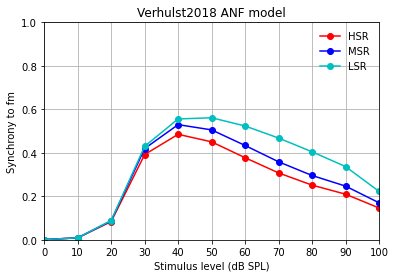

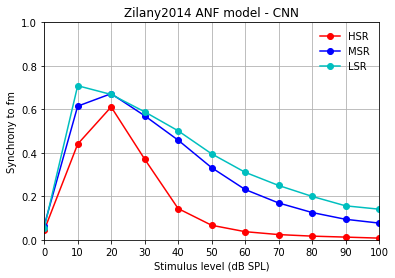

In [11]:
############ Plots ###################
# Plot the synchrony-level functions for the reference model
plt.plot(anfh_target_vs.T,'ro-')
plt.plot(anfm_target_vs.T,'bo-')
plt.plot(anfl_target_vs.T,'co-')
plt.xlim(0,10), plt.grid(which='both'), 
plt.ylim(0,1)
plt.xticks(ticks=L/10 , labels=L.astype(int))
plt.xlabel('Stimulus level (dB SPL)')
plt.ylabel('Synchrony to fm')
plt.title('Verhulst2018 ANF model')
plt.legend(['HSR','MSR','LSR'], frameon=False)
plt.show()

# Plot the synchrony-level functions for the CoNNear model
plt.plot(anfh_connear_vs.T,'ro-')
plt.plot(anfm_connear_vs.T,'bo-')
plt.plot(anfl_connear_vs.T,'co-')
plt.xlim(0,10), plt.grid(which='both'), 
plt.ylim(0,1)
plt.xticks(ticks=L/10 , labels=L.astype(int))
plt.xlabel('Stimulus level (dB SPL)')
plt.ylabel('Synchrony to fm')
plt.title('Zilany2014 ANF model - CNN')
plt.legend(['HSR','MSR','LSR'], frameon=False)
plt.show()

del anfh, anfm, anfl # remove the connear models variables to free-up some memory